In [11]:
from art.estimators.classification import PyTorchClassifier
from art.defences.detector.poison import ActivationDefence, SpectralSignatureDefense
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [21]:
# Define transforms
transform_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
transform_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load MNIST
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)
mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
mnist_testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=64, shuffle=False)

# Load CIFAR-10
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)
cifar_trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=64, shuffle=True)
cifar_testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
from backdoor_cs612.model_mnist import MNISTNet
from backdoor_cs612.model_cifar10 import CIFAR10Net

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Try Mode Connectivity Analysis

In [26]:
def train(model, dataloader, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            print('loss: {:.4f} [{}/{}]'.format(loss, current, size))

def test(model, dataloader, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval()
    loss, correct = 0.0, 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            pred = model(x)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.int).sum().item()

    loss /= num_batches
    correct /= size
    print('Test Error: \n Accuracy: {:.2f}%, Avg loss: {:.4f}\n'.format(100 * correct, loss))

In [27]:
clean_mnistnet = MNISTNet().to(device)
optimizer = torch.optim.Adam(clean_mnistnet.parameters())
criterion = torch.nn.CrossEntropyLoss()

num_of_epochs = 20

for epoch in range(num_of_epochs):
    print('\n------------- Epoch {} -------------\n'.format(epoch))
    train(clean_mnistnet, mnist_trainloader, criterion, optimizer, device)
    test(clean_mnistnet, mnist_testloader, criterion, device)

torch.save(clean_mnistnet.state_dict(), './clean_mnistnet.pt')


------------- Epoch 0 -------------

loss: 2.2878 [0/60000]
loss: 1.7102 [6400/60000]
loss: 1.2690 [12800/60000]
loss: 0.8698 [19200/60000]
loss: 0.6331 [25600/60000]
loss: 0.6782 [32000/60000]
loss: 0.7421 [38400/60000]
loss: 0.5404 [44800/60000]
loss: 0.7166 [51200/60000]
loss: 0.7235 [57600/60000]
Test Error: 
 Accuracy: 79.85%, Avg loss: 0.6023


------------- Epoch 1 -------------

loss: 0.4935 [0/60000]
loss: 0.8206 [6400/60000]
loss: 0.4793 [12800/60000]
loss: 0.3512 [19200/60000]
loss: 0.3789 [25600/60000]
loss: 0.5696 [32000/60000]
loss: 0.4042 [38400/60000]
loss: 0.3581 [44800/60000]
loss: 0.7948 [51200/60000]
loss: 0.4292 [57600/60000]
Test Error: 
 Accuracy: 81.20%, Avg loss: 0.5607


------------- Epoch 2 -------------

loss: 0.5781 [0/60000]
loss: 0.4970 [6400/60000]
loss: 0.5971 [12800/60000]
loss: 0.7264 [19200/60000]
loss: 0.3828 [25600/60000]
loss: 0.4824 [32000/60000]
loss: 0.4446 [38400/60000]
loss: 0.6282 [44800/60000]
loss: 0.2588 [51200/60000]
loss: 0.4847 [5760

In [28]:
model_folder = 'backdoor_cs612'
model1 = MNISTNet().to(device)
model1.load_state_dict(torch.load(f'{model_folder}/model1/mnist_bd.pt'))
model1.eval()

MNISTNet(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=10, bias=True)
)

In [30]:
test(model1,mnist_trainloader,criterion,device)

Test Error: 
 Accuracy: 32.70%, Avg loss: 7.0230



In [44]:
def interpolate_models(model1, model2, alpha):
    interpolated_state_dict = {}
    for key in model1.state_dict().keys():
        interpolated_state_dict[key] = (1 - alpha) * model1.state_dict()[key] + alpha * model2.state_dict()[key]
    return interpolated_state_dict

import matplotlib.pyplot as plt

def connectivity_analysis(backdoored_model,clean_model,model,data_loader,device,num_classes):
    class_losses = {c: [] for c in range(num_classes)}
    alphas = torch.linspace(0, 1, steps=50)  # 50 steps for interpolation
    losses = []

    for alpha in alphas:
        interpolated_model = model.to(device)
        interpolated_model.load_state_dict(interpolate_models(backdoored_model, clean_model, alpha))
        interpolated_model.eval()
        
        for c in range(num_classes):
            class_loss = 0
            count = 0
            with torch.no_grad():
                for x, y in data_loader:
                    x, y = x.to(device), y.to(device)
                    mask = y == c
                    if mask.sum() > 0:
                        outputs = interpolated_model(x[mask])
                        loss = criterion(outputs, y[mask])
                        class_loss += loss.item() * mask.sum().item()
                        count += mask.sum().item()
            
            class_losses[c].append(class_loss / count if count > 0 else 0)

    for c, losses in class_losses.items():
        plt.plot(alphas, losses, label=f'Class {c}')

    plt.xlabel('Interpolation Parameter (α)')
    plt.ylabel('Loss')
    plt.title('Class-wise Loss Landscape')
    plt.legend()
    plt.show()

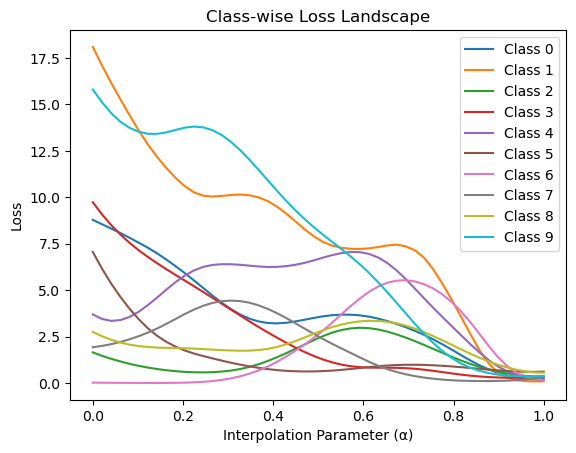

In [45]:
connectivity_analysis(model1,clean_mnistnet,MNISTNet(),mnist_testloader,device,10)

In [46]:
clean_cifar10net = CIFAR10Net().to(device)
optimizer = torch.optim.Adam(clean_cifar10net.parameters())
criterion = torch.nn.CrossEntropyLoss()

num_of_epochs = 20

for epoch in range(num_of_epochs):
    print('\n------------- Epoch {} -------------\n'.format(epoch))
    train(clean_cifar10net, cifar_trainloader, criterion, optimizer, device)
    test(clean_cifar10net, cifar_testloader, criterion, device)

torch.save(clean_cifar10net.state_dict(), './clean_cifar10net.pt')


------------- Epoch 0 -------------

loss: 2.3018 [0/50000]
loss: 1.8907 [6400/50000]
loss: 1.7593 [12800/50000]
loss: 1.7794 [19200/50000]
loss: 1.5703 [25600/50000]
loss: 1.6337 [32000/50000]
loss: 1.2260 [38400/50000]
loss: 1.0912 [44800/50000]
Test Error: 
 Accuracy: 53.70%, Avg loss: 1.2974


------------- Epoch 1 -------------

loss: 1.1529 [0/50000]
loss: 0.9709 [6400/50000]
loss: 0.9416 [12800/50000]
loss: 1.0034 [19200/50000]
loss: 1.1142 [25600/50000]
loss: 1.0110 [32000/50000]
loss: 0.9430 [38400/50000]
loss: 0.8569 [44800/50000]
Test Error: 
 Accuracy: 69.02%, Avg loss: 0.8814


------------- Epoch 2 -------------

loss: 0.7749 [0/50000]
loss: 0.6941 [6400/50000]
loss: 0.8505 [12800/50000]
loss: 0.7840 [19200/50000]
loss: 0.6597 [25600/50000]
loss: 0.9988 [32000/50000]
loss: 0.7708 [38400/50000]
loss: 0.8366 [44800/50000]
Test Error: 
 Accuracy: 73.38%, Avg loss: 0.7761


------------- Epoch 3 -------------

loss: 0.6431 [0/50000]
loss: 0.6649 [6400/50000]
loss: 0.7632 [12

In [34]:
model2 = CIFAR10Net().to(device)
model2.load_state_dict(torch.load(f'{model_folder}/model5/cifar10_bd.pt'))
model2.eval()
test(model2,cifar_testloader,criterion,device)

Test Error: 
 Accuracy: 48.68%, Avg loss: 8.1586



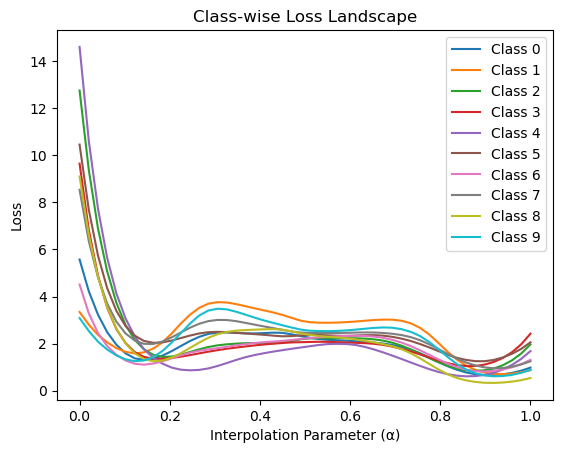

In [47]:
connectivity_analysis(model2,clean_cifar10net,CIFAR10Net(),cifar_testloader,device,10)

### Try Activation Clustering

In [74]:
from art.estimators.classification import PyTorchClassifier
from art.defences.detector.poison import ActivationDefence

def dataloader_to_numpy(dataloader):
    x_list, y_list = [], []
    for images, labels in dataloader:
        x_list.append(images.numpy())
        y_list.append(labels.numpy())
    return np.concatenate(x_list), np.concatenate(y_list)

x_mnist, y_mnist = dataloader_to_numpy(mnist_trainloader)

optimizer = torch.optim.Adam(model1.parameters())
criterion = torch.nn.CrossEntropyLoss()

classifier = PyTorchClassifier(
    model=model1,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),  # Adjust for CIFAR-10 to (3, 32, 32)
    nb_classes=10
)

# Activation defense
activation_defense = ActivationDefence(classifier, x_mnist, y_mnist)
activation_report = activation_defense.detect_poison(nb_clusters=2, cluster_analysis='distance')

# Print out suspicious class
for k,v in activation_report[0].items():
    if 'Class_' in k:
        for cluster,analysis in v.items():
            if analysis['suspicious'] == 'True':
                print(k,cluster)

Class_2 cluster_1
Class_5 cluster_0
Class_5 cluster_1
Class_7 cluster_0


##### Model 2

In [76]:
model2 = CIFAR10Net().to(device)
model2.load_state_dict(torch.load(f'{model_folder}/model2/cifar10_bd.pt'))
model2.eval()
test(model2,cifar_testloader,criterion,device)

x, y = dataloader_to_numpy(cifar_trainloader)

optimizer = torch.optim.Adam(model2.parameters())
criterion = torch.nn.CrossEntropyLoss()

classifier = PyTorchClassifier(
    model=model2,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),  # Adjust for CIFAR-10 to (3, 32, 32)
    nb_classes=10
)

# Activation defense
activation_defense = ActivationDefence(classifier, x, y)
activation_report = activation_defense.detect_poison(nb_clusters=2, cluster_analysis='distance')

# Print out suspicious class
for k,v in activation_report[0].items():
    if 'Class_' in k:
        for cluster,analysis in v.items():
            if analysis['suspicious'] == 'True':
                print(k,cluster)

Test Error: 
 Accuracy: 48.53%, Avg loss: 5.2302

Class_3 cluster_1
Class_4 cluster_1
Class_9 cluster_1


##### Model 3

In [77]:
model3 = CIFAR10Net().to(device)
model3.load_state_dict(torch.load(f'{model_folder}/model3/cifar10_bd.pt'))
model3.eval()
test(model3,cifar_testloader,criterion,device)

x, y = dataloader_to_numpy(cifar_trainloader)

optimizer = torch.optim.Adam(model3.parameters())
criterion = torch.nn.CrossEntropyLoss()

classifier = PyTorchClassifier(
    model=model3,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),  # Adjust for CIFAR-10 to (3, 32, 32)
    nb_classes=10
)

# Activation defense
activation_defense = ActivationDefence(classifier, x, y)
activation_report = activation_defense.detect_poison(nb_clusters=2, cluster_analysis='distance')

# Print out suspicious class
for k,v in activation_report[0].items():
    if 'Class_' in k:
        for cluster,analysis in v.items():
            if analysis['suspicious'] == 'True':
                print(k,cluster)

Test Error: 
 Accuracy: 58.08%, Avg loss: 4.7966

Class_4 cluster_1


##### Model 4

In [78]:
model4 = CIFAR10Net().to(device)
model4.load_state_dict(torch.load(f'{model_folder}/model4/cifar10_bd.pt'))
model4.eval()
test(model4,cifar_testloader,criterion,device)

x, y = dataloader_to_numpy(cifar_trainloader)

optimizer = torch.optim.Adam(model4.parameters())
criterion = torch.nn.CrossEntropyLoss()

classifier = PyTorchClassifier(
    model=model4,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),  # Adjust for CIFAR-10 to (3, 32, 32)
    nb_classes=10
)

# Activation defense
activation_defense = ActivationDefence(classifier, x, y)
activation_report = activation_defense.detect_poison(nb_clusters=2, cluster_analysis='distance')

# Print out suspicious class
for k,v in activation_report[0].items():
    if 'Class_' in k:
        for cluster,analysis in v.items():
            if analysis['suspicious'] == 'True':
                print(k,cluster)

Test Error: 
 Accuracy: 50.83%, Avg loss: 6.5525



##### Model 5

In [79]:
model5 = CIFAR10Net().to(device)
model5.load_state_dict(torch.load(f'{model_folder}/model5/cifar10_bd.pt'))
model5.eval()
test(model5,cifar_testloader,criterion,device)

x, y = dataloader_to_numpy(cifar_trainloader)

optimizer = torch.optim.Adam(model5.parameters())
criterion = torch.nn.CrossEntropyLoss()

classifier = PyTorchClassifier(
    model=model5,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),  # Adjust for CIFAR-10 to (3, 32, 32)
    nb_classes=10
)

# Activation defense
activation_defense = ActivationDefence(classifier, x, y)
activation_report = activation_defense.detect_poison(nb_clusters=2, cluster_analysis='distance')

# Print out suspicious class
for k,v in activation_report[0].items():
    if 'Class_' in k:
        for cluster,analysis in v.items():
            if analysis['suspicious'] == 'True':
                print(k,cluster)

Test Error: 
 Accuracy: 48.68%, Avg loss: 8.1586

